In [1]:
import time

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [3]:
df = pd.read_csv('./full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [4]:
df['label'] = df['filename'].str.split('_').str[-2]

In [5]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

In [6]:

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

In [7]:
def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

In [8]:
columns_to_drop = ['label','filename']

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

In [9]:
num_epochs = 100

num_folds = 5

hidden_layers = [64, 128, 256]

In [10]:
input_shape = X_train.shape[1]

hidden_layers_acc = {}

optimal_batch_size = 1024

for hidden_layer_neurons in hidden_layers:
    print(f'Hidden layer Neurons {hidden_layer_neurons}')
    fold = 0
    acc = []
    cv = KFold(n_splits=num_folds, shuffle=True)

    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        print(f'Fold {fold}')
        X_train_copy, y_train_copy  = X_train.iloc[train_idx], y_train[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train[val_idx]

        X_train_scaled, X_val_scaled = preprocess_dataset(X_train_copy, X_val)
        
        model = Sequential([
            InputLayer(input_shape=(input_shape,)),
            Dense(hidden_layer_neurons, activation='relu'),
            Dropout(0.2),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(128, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])

        optimizer = Adam(learning_rate=0.001)

        model.compile(optimizer=optimizer,
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

        early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
            
        history = model.fit(X_train_scaled, y_train_copy,
                            epochs=num_epochs,
                            verbose=1,
                            batch_size=optimal_batch_size,
                            use_multiprocessing=False,
                            validation_data=(X_val_scaled, y_val),
                            callbacks=[early_stopping_callback] 
                        )
        
        acc.append(history.history['val_accuracy'][-1])
        
        print('fold %d test accuracy %g'%(fold, acc[fold]))
        fold += 1
        
    print('* mean accuracy = %g *'% np.mean(acc))
    hidden_layers_acc[hidden_layer_neurons] = np.mean(acc)

Hidden layer Neurons 64
Fold 0
Epoch 1/100
100/100 [==============================] - 1s 7ms/step - loss: 0.6932 - accuracy: 0.5267 - val_loss: 0.6868 - val_accuracy: 0.5408
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.6871 - accuracy: 0.5419 - val_loss: 0.6855 - val_accuracy: 0.5448
Epoch 3/100
100/100 [==============================] - 1s 6ms/step - loss: 0.6849 - accuracy: 0.5482 - val_loss: 0.6839 - val_accuracy: 0.5473
Epoch 4/100
100/100 [==============================] - 1s 5ms/step - loss: 0.6831 - accuracy: 0.5546 - val_loss: 0.6836 - val_accuracy: 0.5502
Epoch 5/100
100/100 [==============================] - 1s 5ms/step - loss: 0.6820 - accuracy: 0.5555 - val_loss: 0.6821 - val_accuracy: 0.5528
Epoch 6/100
100/100 [==============================] - 1s 5ms/step - loss: 0.6805 - accuracy: 0.5603 - val_loss: 0.6806 - val_accuracy: 0.5590
Epoch 7/100
100/100 [==============================] - 1s 5ms/step - loss: 0.6801 - accuracy: 0.5615 - val_loss

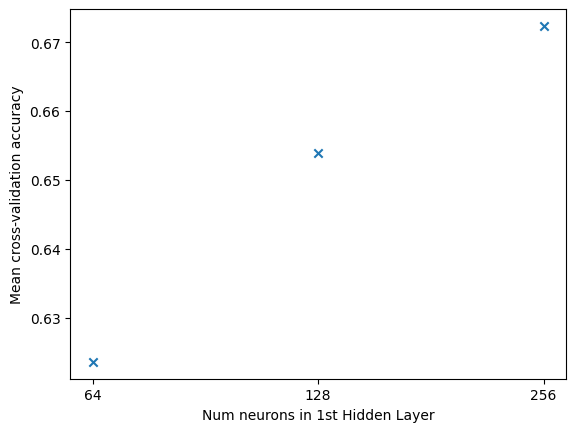

In [11]:
fig, ax = plt.subplots()
ax.scatter([str(hidden_layers) for hidden_layers in hidden_layers_acc.keys()], hidden_layers_acc.values(),  marker = 'x')
plt.xlabel('Num neurons in 1st Hidden Layer')
plt.ylabel('Mean cross-validation accuracy')
plt.show()

In [12]:
optimal_batch_size = 1024
optimal_hidden_layer_size = 256

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

model = Sequential([
    InputLayer(input_shape=(input_shape,)),
    Dense(optimal_hidden_layer_size, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
    
history = model.fit(X_train_scaled, y_train,
                    epochs=num_epochs,
                    verbose=2,
                    batch_size=optimal_batch_size,
                    use_multiprocessing=False,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stopping_callback] 
                )

Epoch 1/100
125/125 - 12s - loss: 0.6915 - accuracy: 0.5350 - val_loss: 0.6851 - val_accuracy: 0.5520 - 12s/epoch - 95ms/step
Epoch 2/100
125/125 - 8s - loss: 0.6841 - accuracy: 0.5519 - val_loss: 0.6814 - val_accuracy: 0.5594 - 8s/epoch - 67ms/step
Epoch 3/100
125/125 - 9s - loss: 0.6806 - accuracy: 0.5611 - val_loss: 0.6804 - val_accuracy: 0.5618 - 9s/epoch - 75ms/step
Epoch 4/100
125/125 - 8s - loss: 0.6775 - accuracy: 0.5666 - val_loss: 0.6762 - val_accuracy: 0.5690 - 8s/epoch - 66ms/step
Epoch 5/100
125/125 - 9s - loss: 0.6735 - accuracy: 0.5759 - val_loss: 0.6731 - val_accuracy: 0.5777 - 9s/epoch - 71ms/step
Epoch 6/100
125/125 - 8s - loss: 0.6702 - accuracy: 0.5836 - val_loss: 0.6700 - val_accuracy: 0.5820 - 8s/epoch - 65ms/step
Epoch 7/100
125/125 - 9s - loss: 0.6665 - accuracy: 0.5877 - val_loss: 0.6659 - val_accuracy: 0.5874 - 9s/epoch - 72ms/step
Epoch 8/100
125/125 - 9s - loss: 0.6617 - accuracy: 0.5951 - val_loss: 0.6620 - val_accuracy: 0.5941 - 9s/epoch - 70ms/step
Epoch 

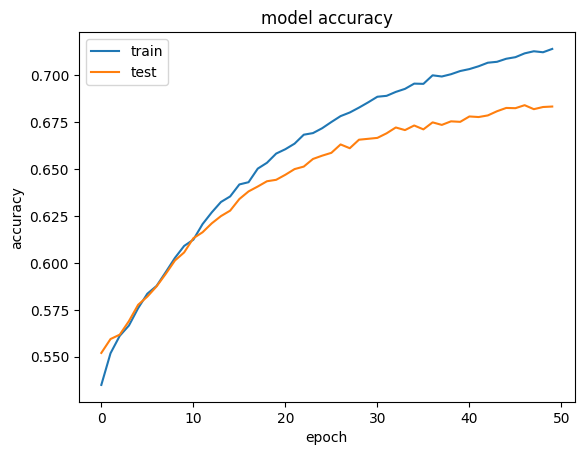

In [13]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

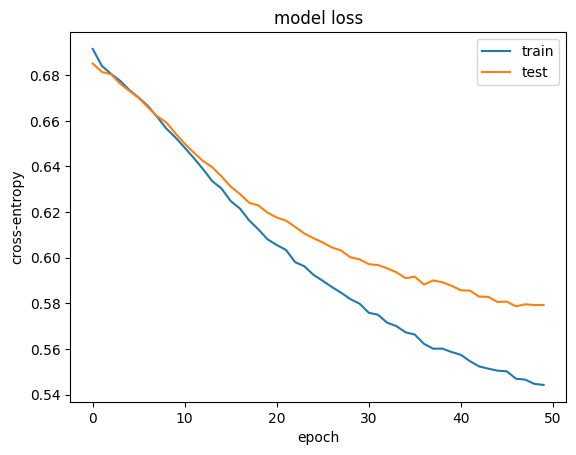

In [14]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [15]:
optimal_batch_size = 1024
optimal_hidden_layer_size = 256

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

model = Sequential([
    InputLayer(input_shape=(input_shape,)),
    Dense(optimal_hidden_layer_size, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
    
history = model.fit(X_train_scaled, y_train,
                    epochs=num_epochs,
                    verbose=2,
                    batch_size=optimal_batch_size,
                    use_multiprocessing=False,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stopping_callback] 
                )

Epoch 1/100
125/125 - 10s - loss: 0.7176 - accuracy: 0.5369 - val_loss: 0.7097 - val_accuracy: 0.5517 - 10s/epoch - 80ms/step
Epoch 2/100
125/125 - 6s - loss: 0.7065 - accuracy: 0.5521 - val_loss: 0.7028 - val_accuracy: 0.5548 - 6s/epoch - 50ms/step
Epoch 3/100
125/125 - 7s - loss: 0.6995 - accuracy: 0.5619 - val_loss: 0.6980 - val_accuracy: 0.5610 - 7s/epoch - 56ms/step
Epoch 4/100
125/125 - 6s - loss: 0.6933 - accuracy: 0.5677 - val_loss: 0.6918 - val_accuracy: 0.5676 - 6s/epoch - 51ms/step
Epoch 5/100
125/125 - 2s - loss: 0.6880 - accuracy: 0.5746 - val_loss: 0.6868 - val_accuracy: 0.5761 - 2s/epoch - 18ms/step
Epoch 6/100
125/125 - 1s - loss: 0.6832 - accuracy: 0.5829 - val_loss: 0.6833 - val_accuracy: 0.5812 - 1s/epoch - 12ms/step
Epoch 7/100
125/125 - 1s - loss: 0.6781 - accuracy: 0.5879 - val_loss: 0.6784 - val_accuracy: 0.5844 - 1s/epoch - 11ms/step
Epoch 8/100
125/125 - 1s - loss: 0.6728 - accuracy: 0.5972 - val_loss: 0.6733 - val_accuracy: 0.5952 - 1s/epoch - 10ms/step
Epoch 

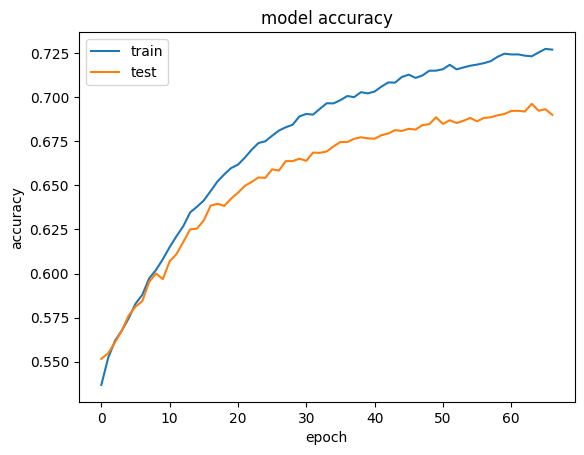

In [16]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

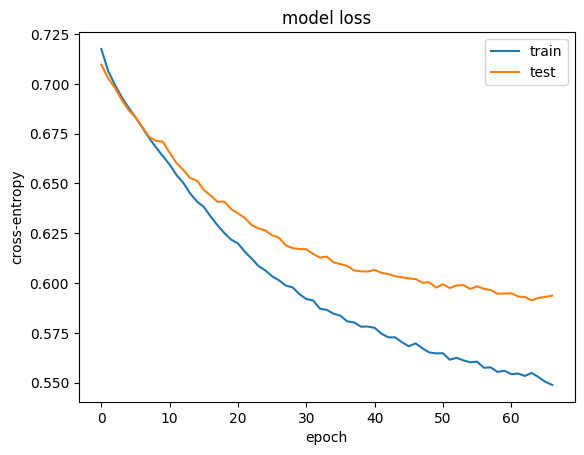

In [17]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('cross-entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')